In [1]:
import cv2
import albumentations as alb
import os
import pandas as pd 
import numpy as  np 
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D, Dense, Input, MaxPooling2D,
    LeakyReLU, BatchNormalization, 
    GlobalAveragePooling2D, Dropout,
    Flatten, PReLU, ReLU
)
from tensorflow.keras.models import  Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2

In [2]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [3]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [4]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, img_path, annotations, batch_size, augment, img_shape, shuffle=True, training=True):
        self.img_paths = img_path 
        self.augment = augment
        self.annotations = annotations
        self.indices = np.arange(len(img_path))
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        x = len(self.img_paths)//self.batch_size
        x += int((len(self.img_paths)%self.batch_size)!=0)
        return x
    
    def __getitem__(self, idx):
        batch_img_path = self.img_paths[self.indices[self.batch_size*idx: self.batch_size*(idx+1)]]
        batch_annotations = self.annotations[self.indices[self.batch_size*idx: self.batch_size*(idx+1)]]
        batch_img, batch_annotations = self._data_generator(batch_img_path, batch_annotations)
        return batch_img, batch_annotations
        
    
    def _data_generator(self, batch_img_path, batch_annotations):
        imgs = []
        annotations = []
        for num, (img_path, annotation) in enumerate(zip(batch_img_path, batch_annotations)):
            img = np.array(Image.open(img_path).convert('RGB'))
            H, W, _ = img.shape
            x = annotation[0]/W
            y = annotation[1]/H
            w = annotation[2]/W
            h = annotation[3]/H
            annotations.append([x, y, w, h])
            img = self.augment(image=img)['image']
            imgs.append(img)
        imgs = np.array(imgs)
        annotations = np.array(annotations)
        return imgs, annotations
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [5]:
def model(img_shape):
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    head_model = base_model.output
    x = GlobalAveragePooling2D()(head_model)
    x = Dense(100)(x)
    x = PReLU()(x)
    x = Dense(50)(x)
    x = PReLU()(x)
    x = Dense(25)(x)
    x = PReLU()(x)
    x = Dense(4, activation='sigmoid')(x)
    model = Model(base_model.input, x)
    return model

In [6]:
img_shape = (224, 224, 3)

train_augment = alb.Compose([
    alb.Normalize(max_pixel_value=255.0, always_apply=True),
    alb.Resize(img_shape[0], img_shape[1], always_apply=True),
])

val_augment = alb.Compose([
    alb.Normalize(max_pixel_value=255.0, always_apply=True),
    alb.Resize(img_shape[0], img_shape[1], always_apply=True),
])

In [7]:
images_path = 'Face_images'
annotations_path = 'Face_Annotations'
image_files = os.listdir(images_path)

annotations = []
images = []

for image_file in image_files:
    annotation_file_path = annotations_path + '/' + image_file.split('.')[0] + '.mat' 
    image_path = os.path.join(images_path, image_file)
    annotation = scipy.io.loadmat(annotation_file_path)['box_coord'][0]
    images.append(image_path)
    annotations.append([int(annotation[2]), int(annotation[0]), int(annotation[3])- int(annotation[2]), int(annotation[1])- int(annotation[0])])

images = np.array(images)
annotations = np.array(annotations)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(images, annotations, test_size=0.1)

In [9]:
Epochs = 20
Batch_Size = 32
lr = 1e-3
optimizer = keras.optimizers.Adam(lr=1e-4)

In [10]:
train_loader = DataLoader(x_train, y_train, Batch_Size, train_augment, img_shape)
val_loader = DataLoader(x_val, y_val, Batch_Size, val_augment, img_shape)

In [11]:
model = model(img_shape)
model.compile(loss='huber', optimizer=optimizer)

In [12]:
def learning_rate_fn(epoch):
    lr = 1e-3
    lr *= np.exp(-epoch*0.05)
    return lr

callbacks = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn, verbose=True)

In [13]:
model.fit(train_loader, epochs=Epochs, batch_size=Batch_Size, validation_data=(val_loader), callbacks=[callbacks])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
25/25 [==============================] - 3s 124ms/step - loss: 0.0094 - val_loss: 0.0037

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000951229424500714.
Epoch 2/20
25/25 [==============================] - 3s 102ms/step - loss: 0.0028 - val_loss: 0.0025

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009048374180359595.
Epoch 3/20
25/25 [==============================] - 3s 103ms/step - loss: 0.0023 - val_loss: 0.0023

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0008607079764250578.
Epoch 4/20
25/25 [==============================] - 3s 103ms/step - loss: 0.0020 - val_loss: 0.0022

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0008187307530779819.
Epoch 5/20
25/25 [==============================] - 3s 105ms/step - loss: 0.0018 - val_loss: 0.0021

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0007788007830714049.
Epoch 6

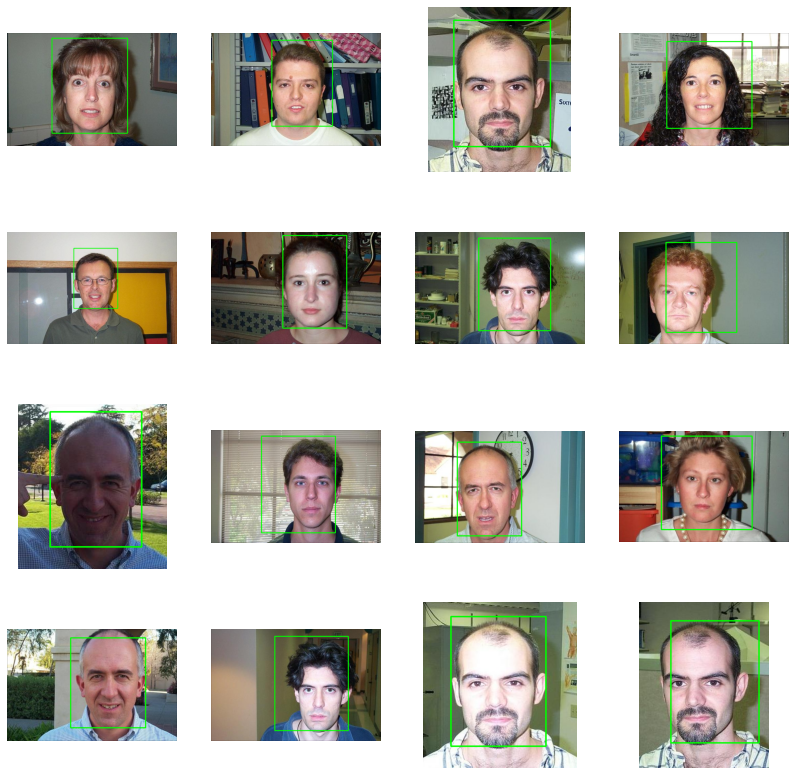

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(14, 14))
for i in range(4):
    for j in range(4):
        idx = np.random.randint(0, len(images))
        img_path = 'Face_images/' + str(idx) + '.jpg'
        image = np.array(Image.open(img_path).convert('RGB'))
        H, W = image.shape[:2]
        image_ = val_augment(image=image)['image']
        image_ = image_[None, :, :, :]
        x, y, w, h = model.predict(image_)[0]
        x *= W
        y *= H
        w *= W
        h *= H
        img = cv2.imread(img_path)
        cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), 2)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')